In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from keras import models, layers, optimizers
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
import os

Using TensorFlow backend.


In [3]:
from os import listdir, makedirs
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

print("Available Pretrained Models:")
!ls ~/.keras/models


Available Pretrained Models:
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
monkey_species = os.listdir('../input/10-monkey-species/training/training')
print("Number of Categories:", len(monkey_species))
print("Categories: ", monkey_species)

Number of Categories: 10
Categories:  ['n5', 'n3', 'n6', 'n4', 'n2', 'n8', 'n0', 'n7', 'n9', 'n1']


In [5]:
# dimensions of our images.
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '../input/10-monkey-species/training/training'
validation_data_dir = '../input/10-monkey-species/validation/validation'
batch_size = 4

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [7]:
nb_train_samples = len(train_generator.classes)
nb_validation_samples = len(validation_generator.classes)

In [8]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [9]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])
testing_data = pd.DataFrame(validation_generator.classes, columns=['classes'])

In [10]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

In [11]:
x1, y1 = create_stack_bar_data('classes', training_data)
x1 = list(train_generator.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1200, title='Class Distribution in Training Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [12]:
x1, y1 = create_stack_bar_data('classes', testing_data)
x1 = list(validation_generator.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1100, title='Class Distribution in Validation Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [13]:
#import inception with pre-trained weights. do not include fully #connected layers
Xception_base = applications.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = Xception_base.output
x = layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = layers.Dense(int(len(train_generator.class_indices.keys())), activation='softmax')(x)
# create the full network so we can train on it
Xception_transfer = models.Model(inputs=Xception_base.input, outputs=predictions)

In [14]:
Xception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9450634448491701519
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15666780570
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14325142457849555337
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [16]:
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history = Xception_transfer.fit_generator(
    train_generator,
    epochs=10, shuffle = True, verbose = 1, validation_data = validation_generator)

Epoch 1/10
275/275 [==============================] - 83s 302ms/step - loss: 2.2729 - acc: 0.1545 - val_loss: 2.1583 - val_acc: 0.2904
Epoch 2/10
275/275 [==============================] - 69s 250ms/step - loss: 2.1598 - acc: 0.3464 - val_loss: 1.9548 - val_acc: 0.5772
Epoch 3/10
275/275 [==============================] - 68s 249ms/step - loss: 1.9825 - acc: 0.5791 - val_loss: 1.6345 - val_acc: 0.7904
Epoch 4/10
275/275 [==============================] - 70s 256ms/step - loss: 1.7413 - acc: 0.7173 - val_loss: 1.2568 - val_acc: 0.8713
Epoch 5/10
275/275 [==============================] - 69s 249ms/step - loss: 1.4630 - acc: 0.7746 - val_loss: 0.9202 - val_acc: 0.9081
Epoch 6/10
275/275 [==============================] - 71s 259ms/step - loss: 1.1768 - acc: 0.8000 - val_loss: 0.6250 - val_acc: 0.9375
Epoch 7/10
275/275 [==============================] - 71s 259ms/step - loss: 0.9337 - acc: 0.8409 - val_loss: 0.4756 - val_acc: 0.9449
Epoch 8/10
275/275 [==============================] - 7

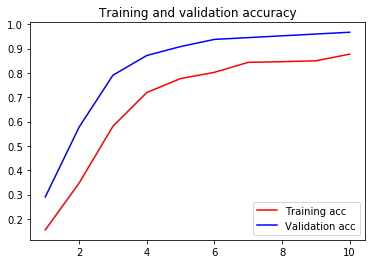

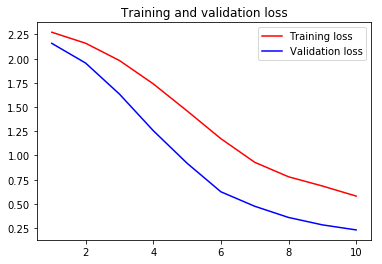

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()